In [1]:
import os
import pickle
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Set the city name or coordinates for Gurgaon
place_name = "Gurgaon, India"

# Download the street network
gurugram_graph = ox.graph_from_place(place_name, network_type="all_private")

In [2]:
study_area = gpd.read_file('geodata/study_area.csv')

# Project the GeoDataFrame to the same CRS as the graph
study_area = study_area.set_crs(gurugram_graph.graph['crs'])

In [3]:
dense_area = gpd.read_file('geodata/dense_area.csv')
dense_area = dense_area.set_crs(gurugram_graph.graph['crs'])
sparse_area = gpd.read_file('geodata/sparse_area.csv')
sparse_area = sparse_area.set_crs(gurugram_graph.graph['crs'])
dark_stores = gpd.read_file('geodata/blinkit_stores.csv')
display(dark_stores)

,WKT,name,description,geometry
0,POINT (77.094912 28.462015 0.0),blinkit,,POINT Z (77.09491 28.46202 0.00000)
1,POINT (77.04601 28.427039 0.0),Blinkit sector 47,,POINT Z (77.04601 28.42704 0.00000)
2,POINT (77.041041 28.461018 0.0),Blinkit online store,,POINT Z (77.04104 28.46102 0.00000)
3,POINT (77.086489 28.472832 0.0),Blinkit store,,POINT Z (77.08649 28.47283 0.00000)
4,POINT (77.072826 28.413124 0.0),Blinkit Store (Online) Sector 50,,POINT Z (77.07283 28.41312 0.00000)
5,POINT (77.056567 28.390908 0.0),BlinkIt Store(Dark Store),,POINT Z (77.05657 28.39091 0.00000)
6,POINT (77.073085 28.441506 0.0),Blinkit warehouse,,POINT Z (77.07309 28.44151 0.00000)
7,POINT (77.045226 28.402609 0.0),Blinkit Dark Store,,POINT Z (77.04523 28.40261 0.00000)
8,POINT (77.059314 28.406399 0.0),Blinkit Dark Store,,POINT Z (77.05931 28.40640 0.00000)
9,POINT (77.035943 28.417696 0.0),Blinkit store sector 48,,POINT Z (77.03594 28.41770 0.00000)


In [4]:
# Create sub-graphs
study_area_graph = ox.graph_from_polygon(study_area.geometry[0], network_type='all_private', retain_all=True)
dense_area_graph = ox.graph_from_polygon(dense_area.geometry[0], network_type='all_private', retain_all=True)
sparse_area_graph = ox.graph_from_polygon(sparse_area.geometry[0], network_type='all_private', retain_all=True)

In [5]:
dark_stores_focused = []

for idx, point in enumerate(dark_stores['geometry']):
    if point.within(dense_area.geometry.values[0]) or point.within(sparse_area.geometry.values[0]):
        dark_stores_focused.append(idx)
        
dark_stores_focused = dark_stores.iloc[dark_stores_focused]

In [6]:
all_nodes = list(dense_area_graph.nodes) + list(sparse_area_graph.nodes)

#### Import all experiment data

In [7]:
# Specify the folder containing the pickle files
simulation_data_dir = "simulation_data"

# Load each list from its corresponding file
with open(os.path.join(simulation_data_dir, "delivery_iterations.pkl"), "rb") as f:
    delivery_iterations = pickle.load(f)

with open(os.path.join(simulation_data_dir, "dense_delivery_iterations.pkl"), "rb") as f:
    dense_delivery_iterations = pickle.load(f)

with open(os.path.join(simulation_data_dir, "sparse_delivery_iterations.pkl"), "rb") as f:
    sparse_delivery_iterations = pickle.load(f)

with open(os.path.join(simulation_data_dir, "simulation_data.pkl"), "rb") as f:
    simulation_data = pickle.load(f)

In [8]:
num_simulations = len(simulation_data)

In [9]:
# Check the shape of our simulation data for the dense zone
temp = pd.DataFrame(dense_delivery_iterations)
display(temp.shape)
del temp

(1, 15)

In [10]:
# get the number of delivery points and executives (per zone)
num_delivery_points = pd.DataFrame(dense_delivery_iterations).shape[1]
num_delivery_executives = num_delivery_points // 5

delivery_executives = random.choices(all_nodes, k=num_delivery_points)

#### Visualize the network on the map

/var/folders/lt/njk9c7vd43n4xfmcy1kt75c40000gn/T/ipykernel_63265/167740875.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(['Service Areas', 'Dense Customers', 'Sparse Customers', 'Dark Stores'])


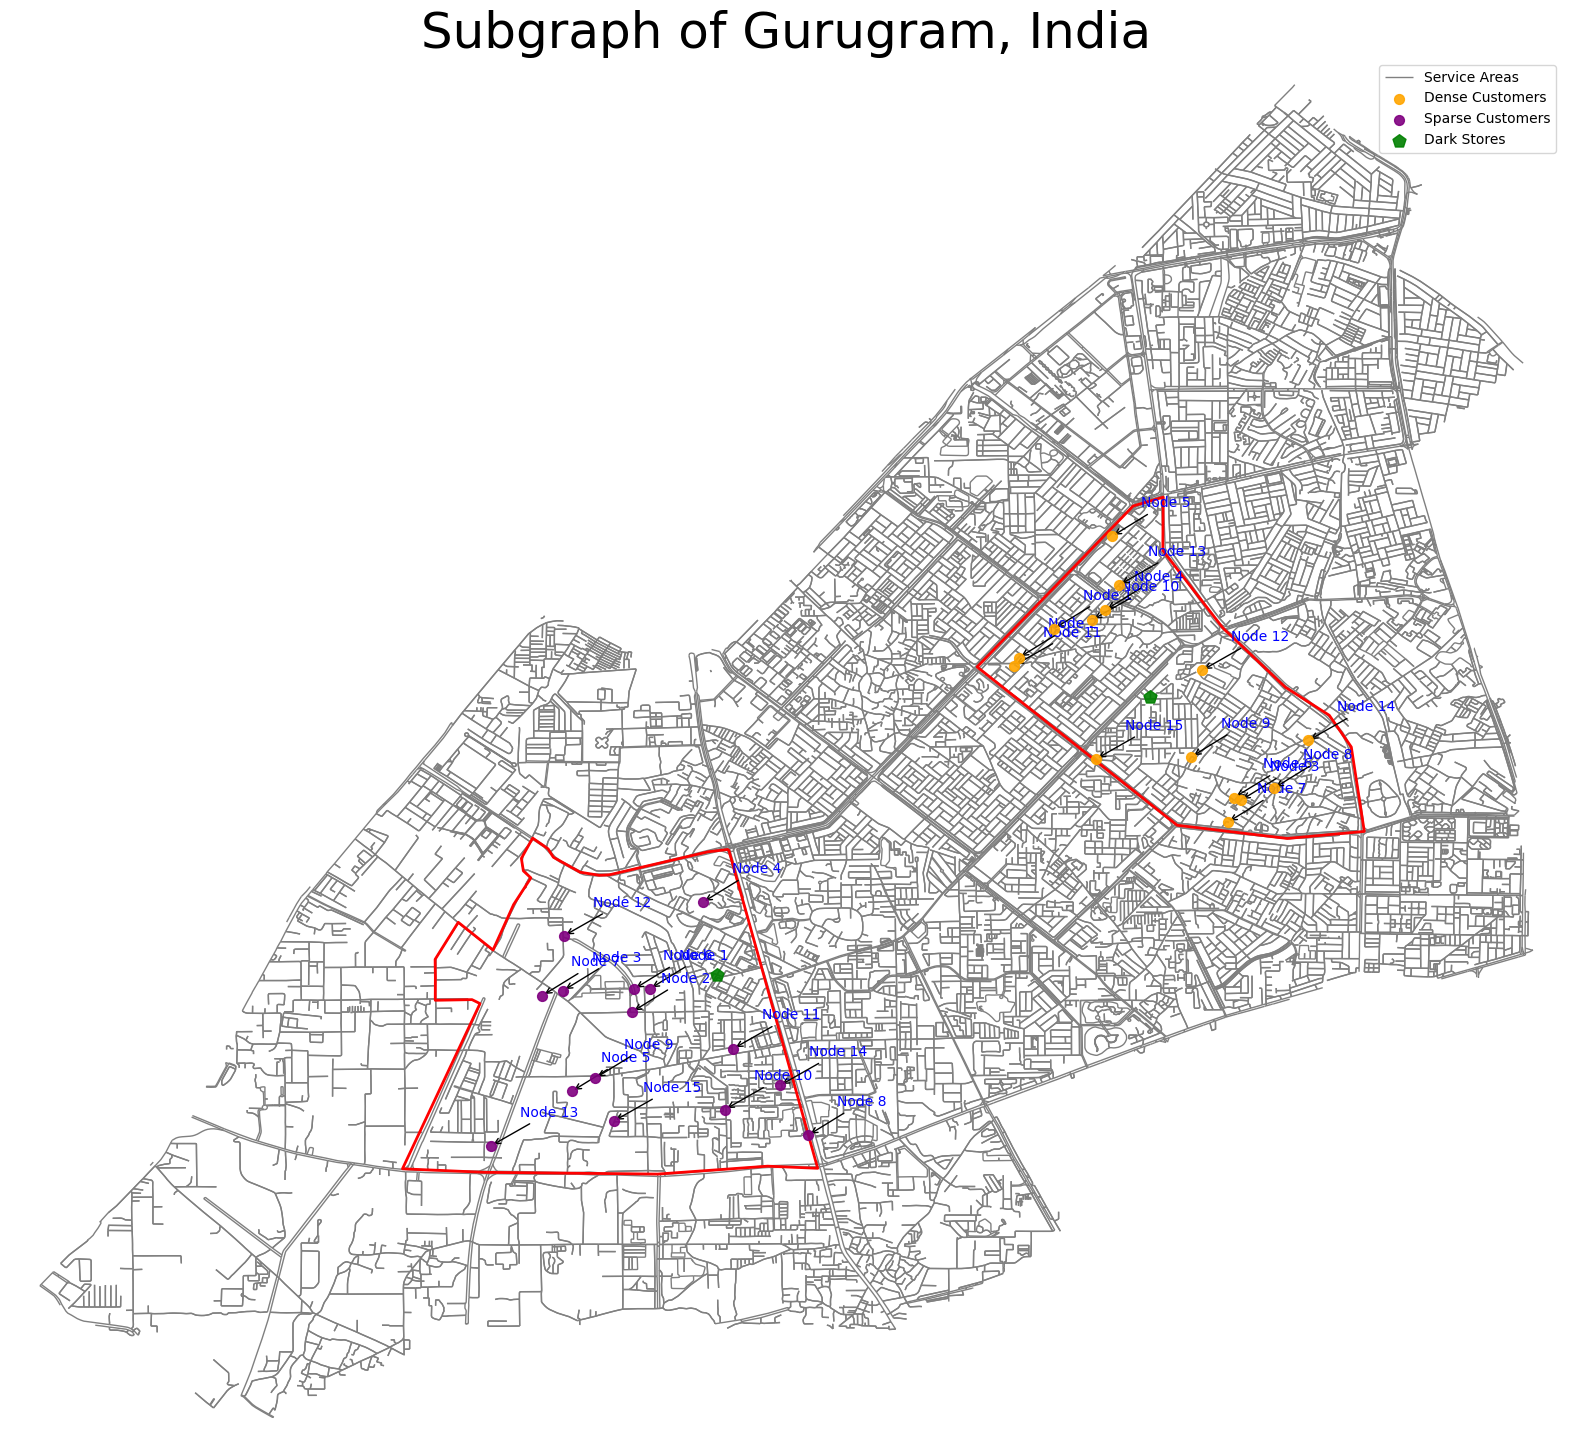

In [11]:
figsize = (32, 18)

fig, ax = ox.plot_graph(study_area_graph, node_size=0, edge_color="gray", bgcolor="white", show=False, figsize=figsize)

ax.scatter(np.array(dense_delivery_iterations[0])[:, 0], np.array(dense_delivery_iterations[0])[:, 1], c="orange", s=50, zorder=4, alpha=0.9, label=range(num_delivery_points))
ax.scatter(np.array(sparse_delivery_iterations[0])[:, 0], np.array(sparse_delivery_iterations[0])[:, 1], c="purple", s=50, zorder=4, alpha=0.9)

offset = 0.00075
offset = 0.0025

#Use the annotate() function to annotate each data point with arrows in the scatter plot
for i in range(num_delivery_points) :
    ax.annotate(f'Node {i+1}', (np.array(dense_delivery_iterations[0])[:, 0][i], np.array(dense_delivery_iterations[0])[:, 1][i]), xytext=(
    np.array(dense_delivery_iterations[0])[:, 0][i] + offset, np.array(dense_delivery_iterations[0])[:, 1][i] + offset), arrowprops=dict(arrowstyle='->'), color='blue')
    ax.annotate(f'Node {i+1}', (np.array(sparse_delivery_iterations[0])[:, 0][i], np.array(sparse_delivery_iterations[0])[:, 1][i]), xytext=(
    np.array(sparse_delivery_iterations[0])[:, 0][i] + offset, np.array(sparse_delivery_iterations[0])[:, 1][i] + offset), arrowprops=dict(arrowstyle='->'), color='blue')

dense_area.plot(ax=ax, color="none", edgecolor="red", linewidth=2, label='Study Area')
sparse_area.plot(ax=ax, color="none", edgecolor="red", linewidth=2)
dark_stores_focused.plot(ax=ax, color="green", marker='p', markersize=96, alpha=0.9)
ax.set_title("Subgraph of Gurugram, India", fontsize=36)

plt.legend(['Service Areas', 'Dense Customers', 'Sparse Customers', 'Dark Stores'])
plt.show()

## Simulate Performance with Proposed Model

#### Define method for running and reporting the simulation

In [12]:
def get_solution(data, manager, routing, solution):
    current_time_matrix = data['derived_time_matrix']
    current_distance_matrix = data['distance_matrix']
    display(pd.DataFrame(current_time_matrix))
    
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_time = 0
    
    total_driving_time = 0
    total_distance = 0
    total_emissions = 0
    total_cost = 0

    for route_id in range(data["num_vehicles"]):
        index = routing.Start(route_id)
        plan_output = f"Route for vehicle {route_id}:\n"
        
        route_time = 0
        route_distance = 0
        route_emissions = 0
        route_fuel_cost = 0
        
        # Route to the next link
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))

            # link_time = routing.GetArcCostForVehicle(
            #     previous_index, index, vehicle_id
            # )

            link_time = current_time_matrix[manager.IndexToNode(previous_index)][manager.IndexToNode(index)]
            link_distance = current_distance_matrix[manager.IndexToNode(previous_index)][manager.IndexToNode(index)]
            link_emissions = get_link_emissions(link_time)
            link_fuel_cost = get_link_cost(link_time)

            route_time += link_time
            route_distance += link_distance
            route_emissions += link_emissions
            route_fuel_cost += link_fuel_cost
            
            print(f"Travel time between Node {manager.IndexToNode(previous_index)} and Node {manager.IndexToNode(index)}: {link_time} min")

        # print(f"Travel time between dark store and node {index}: {route_time} min")


        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Time elapsed on route: {route_time} min\n"
        plan_output += f"Distance travelled on route: {route_distance} km\n"
        plan_output += f"Emissions of the route: {route_emissions:.4} kg CO2\n"
        plan_output += f"Fuel cost of the route: ${route_fuel_cost:.4}"
        print(plan_output)
        print()

        max_route_time = max(route_time, max_route_time)
        
        total_driving_time += route_time
        total_distance += route_distance
        total_emissions += route_emissions
        total_cost += route_fuel_cost
        
        
    print("----------------------------------------")
    print(f"Maximum time spent on a delivery run: {max_route_time} min")
    print()
    print(f"Total time spent on road by all delivery executives: {total_driving_time}")
    print(f"Total emissions from operations: {total_emissions} kg CO2")
    print(f"Total cost of operations: ${total_cost:.3}")
    
    return [max_route_time, total_emissions, total_cost]


In [13]:
simulation_managers = []
simulation_routing = []

for data in simulation_data:
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["derived_time_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    simulation_managers.append(manager)
    simulation_routing.append(routing)

#### Define helper methods

In [14]:
assumed_average_speed = 40 #km/h

In [15]:
def get_link_emissions(time, coef=1.0):
    distance = assumed_average_speed * time / 60
    print(f'Distance travelled: {distance:.10}')
    kg_co2_per_km = 0.11337 * coef
    return distance * kg_co2_per_km

def get_link_cost(time, coef=1.0):
    distance = assumed_average_speed * time / 60
    fuel_consumption_rate_per_km = 0.0166 * coef
    dollar_price_per_liter = 1.17
    
    return distance * fuel_consumption_rate_per_km * dollar_price_per_liter

#### Define callback to add elapsed time to route

In [16]:
def elapsed_time_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    return data["derived_time_matrix"][from_node][to_node]

In [17]:
proposed_system_simulation_results = pd.DataFrame(index=range(num_simulations), columns=['maximum_individual_link_time', 'total_emissions', 'cost'])

for i in range(num_simulations):
    data = simulation_data[i]
    routing = simulation_routing[i]
    manager = simulation_managers[i]
    
    transit_callback_index = routing.RegisterTransitCallback(elapsed_time_callback)
    
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Add Time constraint.
    dimension_name = "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        42,  # maximum delivery time
        True,  # start cumul to zero
        dimension_name,
    )
    time_dimension = routing.GetDimensionOrDie(dimension_name)
    time_dimension.SetGlobalSpanCostCoefficient(100)
    
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    
    # Set the heuristic to Clarke-Wright Savings Method
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.SAVINGS
    )
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    
    # Print solution on console.
    if solution:
        proposed_system_simulation_results.iloc[i] = get_solution(data, manager, routing, solution)
    else:
        print("No solution found !")
    

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0000,2.5875,2.8410,2.5935,2.4150,3.9165,2.4555,3.5310,4.4130,1.6290,2.1645,2.3655,2.2980,2.9265,3.8595,1.4430
1,3.5235,0.0000,1.9050,6.0990,0.9600,2.3025,5.4855,5.3625,6.2430,4.8375,0.7110,1.7985,5.7735,1.3110,6.6825,3.2745
2,4.0215,1.9050,0.0000,5.8215,1.7325,2.6925,5.2080,5.0850,5.9670,4.5615,1.4820,0.7950,6.2730,2.0835,7.4535,3.1575
3,2.5935,4.8885,5.9145,0.0000,5.6940,6.0900,0.1305,0.9495,0.7395,1.1490,4.4670,5.7930,4.2555,5.5755,1.6590,2.4780
4,2.7840,0.9600,1.7325,5.9265,0.0000,1.5645,5.3130,5.1900,6.0705,4.6650,0.2280,1.6260,5.0355,0.5730,5.9430,3.1020
5,3.6795,2.3610,2.4060,7.4670,1.6215,0.0000,6.8535,6.7305,7.6110,6.2055,1.9395,2.7075,4.9995,1.4685,5.6835,4.6425
6,2.4555,4.7490,5.9580,0.1305,5.5545,5.9505,0.0000,0.9915,0.7830,1.0095,4.3275,4.5285,4.1160,5.4360,1.7025,2.3385
7,2.7345,5.9580,5.7165,0.9495,6.3675,6.6855,0.9915,0.0000,1.0950,1.7445,5.5365,5.5935,4.8510,6.2490,2.0145,2.4795
8,2.8215,5.9685,6.0600,0.7395,5.2305,5.6250,0.7830,1.0950,0.0000,1.3755,5.5470,5.9385,3.7905,5.1105,0.9195,2.7045
9,1.5600,5.3805,4.3560,1.1265,4.6425,5.0370,0.9870,1.6815,1.3545,0.0000,4.9590,3.8805,3.2025,4.5225,3.2535,1.6920


Objective: 612
Distance travelled: 0.0
Travel time between Node 0 and Node 0: 0.0 min
Route for vehicle 0:
 0 -> 0
Time elapsed on route: 0.0 min
Distance travelled on route: 0.0 km
Emissions of the route: 0.0 kg CO2
Fuel cost of the route: $0.0

Distance travelled: 1.894
Travel time between Node 0 and Node 2: 2.8409999999999997 min
Distance travelled: 0.53
Travel time between Node 2 and Node 11: 0.795 min
Distance travelled: 1.199
Travel time between Node 11 and Node 1: 1.7985000000000002 min
Distance travelled: 0.474
Travel time between Node 1 and Node 10: 0.711 min
Distance travelled: 0.152
Travel time between Node 10 and Node 4: 0.228 min
Distance travelled: 0.382
Travel time between Node 4 and Node 13: 0.573 min
Distance travelled: 0.661
Travel time between Node 13 and Node 5: 0.9915 min
Distance travelled: 2.453
Travel time between Node 5 and Node 0: 3.6795 min
Route for vehicle 1:
 0 ->  2 ->  11 ->  1 ->  10 ->  4 ->  13 ->  5 -> 0
Time elapsed on route: 11.6175 min
Distance tr

In [18]:
display(proposed_system_simulation_results)

,maximum_individual_link_time,total_emissions,cost
0,12.7845,1.844303,0.315957
